# House price predictions with neural networks

Small example to train a neural network to predict house prices using a simple multi-layer neural network in Scikit-learn. Data is available on [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction).

---
## Useful Jupyter Shortcuts

Below is a (far from comprehensive) shortcut list for Jupyter Notebooks:

* `shift` + `Enter`: Run cell
* `enter`: Enter *write* mode
* `esc`: Exit *write* mode and enter *navigation* mode
* (in nav. mode) `a`: Add cell above current cell
* (in nav. mode) `b`: Add cell below current cell
* (in nav. mode) `m`: Turn current cell into text
* (in nav. mode) `y`: Turn current cell into code
* (in nav. mode) `d` x2: Delete current cell
* `tab`: Tab completion
* `shift` + `tab`: Show documentation / parameters

Some Jupyter / iPython magic:

* Add `?` at the beginning of a command to see documentation for the function/method/etc
* Add `%matplotlib inline` at the beginning of your notebook for in-line plots

And some useful configurations:

* `plt.rcParams['figure.figsize'] = (18.0, 12.0)`: Set the default matplotlib figure size
* `pd.set_option('display.max_columns', None)`: Asks pandas to show us **all** columns in dataframes

To get rid of the margin and make the cells cover 100% of the window width run the below code block:
```
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
```

---

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (14.0, 8.0)
pd.set_option('display.max_columns', None)
%matplotlib inline

## Loading and Exploring the Data

First lets read our data into memory and view the top rows using the pandas `head()` function:


In [2]:
data = pd.read_csv('kc_house_data.csv')

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Understanding your data is one of the most important preprocessing steps before tackling a data science problem. One of the easiest ways to look for initial correlations is to plot a correlation matrix. This can help us determine which columns are important and which columns are expendable. It is important to remember however, whilst some fields may have low correlations in their current form this does not mean they cannot be useful with the aid of some further preprocessing.

In [3]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


For datasets wity features, examining the output of a correlation matrix can get complicated. One approach is to filter by price column and sort descending:

In [4]:
corr_mat = data.corr()
corr_mat['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

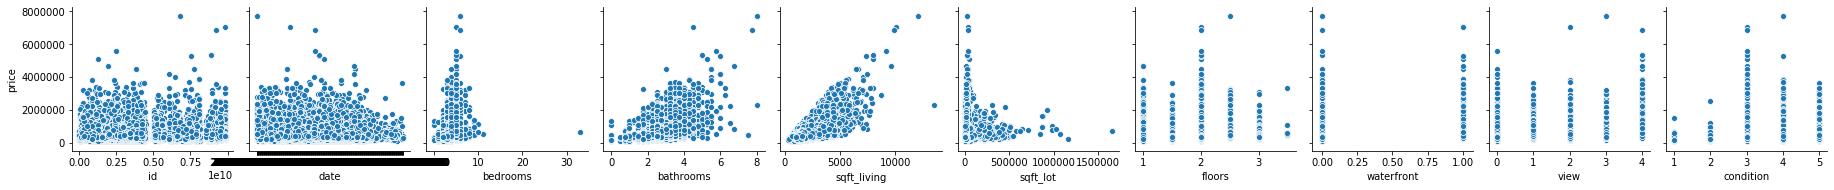

In [5]:
sns.pairplot(data, x_vars=data.columns.drop('price')[:10], y_vars=['price'])

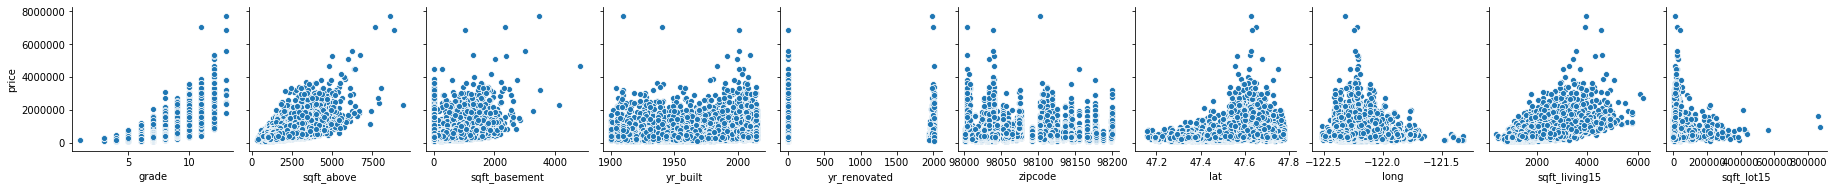

In [6]:
sns.pairplot(data, x_vars=data.columns.drop('price')[10:], y_vars=['price'])

## Data cleaning and preprocessing

The first thing we need to do before we are ready to train a neural network is prepare our data. First we will split our labels from the main dataset and remove any unwanted fields that may confuse the model.

In [7]:
labels = data['price']
features = data.drop(['id', 'date', 'price', 'zipcode', 'lat', 'long'], axis=1)

print(features.shape, labels.shape)

(21613, 15) (21613,)


Remember that a crucial step in our modelling pipeline is to **split our data into a train and a test set**. This is because (and this is particularly relevant to neural networks) we want our models to generalize well to data that they haven't seen, and so we don't want the models to simply 'memorize' the training data, a phenomenon known as **overfitting**.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels.values, test_size=0.33, random_state=42)

print('Train Size', X_train.shape, y_train.shape)
print('Test Size', X_test.shape, y_test.shape)

Train Size (14480, 15) (14480,)
Test Size (7133, 15) (7133,)


Here we use the scikit learning preprocessing class to scale our input data. This is important as large numbers can be problematic for neural networks. To account for this we use a **StandardScaler** which standardised features by centering each feature around 0, and making its standard deviation (the spread) equal to one. In this way, inherent differences in scale between features (for example sqft_living which can easily get into the hundreds and bathrooms which can be at most a couple dozen) don't confuse the network. We can further motivate the need for a standard scaler by looking at some statistics for our features using pandas' `describe` method:

In [9]:
X_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,14480.000000,14480.000000,14480.000000,1.448000e+04,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000,14480.000000
mean,3.367680,2.113225,2075.768439,1.505100e+04,1.499033,0.006906,0.231423,3.410152,7.653177,1786.859185,288.909254,1971.083702,82.410566,1983.502348,12809.173412
std,0.935538,0.766134,909.091142,3.980053e+04,0.542292,0.082818,0.758018,0.651366,1.172298,826.407904,439.209514,29.387281,397.088523,682.589466,27273.288544
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,399.000000,651.000000
25%,3.000000,1.500000,1420.000000,5.008750e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,1483.250000,5100.000000
50%,3.000000,2.250000,1910.000000,7.574000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,1840.000000,7606.500000
75%,4.000000,2.500000,2550.000000,1.064050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,2360.000000,10070.000000
max,33.000000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,6210.000000,871200.000000


In [10]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's quickly examine the result of scaling by turning our scaled features (now a numpy array) into a dataframe (keeping the same column names as our features) and using the `describe` method again:

In [11]:
pd.DataFrame(X_train, columns=features.columns).describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04,1.448000e+04
mean,7.311524e-17,-5.692193e-17,2.085502e-16,5.397769e-18,1.373978e-17,3.434944e-17,1.275836e-17,2.674349e-16,1.521190e-17,-3.189591e-17,-6.771747e-17,2.009933e-15,4.023792e-17,8.783643e-17,-3.140520e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-3.599849e+00,-2.758392e+00,-1.964413e+00,-3.651083e-01,-9.202621e-01,-8.339126e-02,-3.053103e-01,-3.700280e+00,-5.675523e+00,-1.811346e+00,-6.578164e-01,-2.418943e+00,-2.075442e-01,-2.321391e+00,-4.458059e-01
25%,-3.930276e-01,-8.004424e-01,-7.213700e-01,-2.523232e-01,-9.202621e-01,-8.339126e-02,-3.053103e-01,-6.297019e-01,-5.571954e-01,-7.101571e-01,-6.578164e-01,-6.834384e-01,-2.075442e-01,-7.328997e-01,-2.826736e-01
50%,-3.930276e-01,1.785321e-01,-1.823515e-01,-1.878683e-01,1.782960e-03,-8.339126e-02,-3.053103e-01,-6.297019e-01,-5.571954e-01,-2.745218e-01,-6.578164e-01,1.332697e-01,-2.075442e-01,-2.102396e-01,-1.907674e-01
75%,6.759130e-01,5.048570e-01,5.216726e-01,-1.108189e-01,9.238280e-01,-8.339126e-02,-3.053103e-01,9.055874e-01,2.958591e-01,4.999409e-01,6.172455e-01,8.819187e-01,-2.075442e-01,5.515917e-01,-1.004378e-01
max,3.167519e+01,7.684004e+00,1.097203e+01,2.888863e+01,3.689963e+00,1.199166e+01,4.971793e+00,2.440877e+00,4.561132e+00,8.559193e+00,1.031682e+01,1.494450e+00,4.867066e+00,6.192073e+00,3.147477e+01


## Modelling

We are now ready to model. Please note that usually more data pre-processing and exploration is needed before reaching the modelling stage, but since the purpose of this notebook is to illustrate how to train your first neural network, we will stick to the minimal steps performed above.

We will start by building a 'baseline', a simple model we are familiar with and that we can use to judge the improvement of more sophisticated models. For this exercise we will use a Linear Regression as our baseline. It will also serve as an example of how convenient and uniform the sklearn API (the language we use to define, train, and evaluate models) is, and how that allows for quickly trying out new models.

### Creating out baseline

Let's start by training a simple linear regression.

In [12]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Let's evaluate the mean absolute error on the test set:

In [13]:
reg_predictions = reg.predict(X_test)
reg_mae = mean_absolute_error(y_test, reg_predictions)

print("Total error: $%.2f" %reg_mae)

Total error: $142493.49


### Using Neural Networks

Let us now try to improve on that results by using neural networks. As we've seen in the workshop, neural networks have a lot of hyperparameters that need tuning, but let us begin by trying the un-tuned, default neural network see what happens: 

In [14]:
net = MLPRegressor()
net.fit(X_train, y_train)

/Users/tomas.rojo/opt/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

We (may) get a warning telling us that our iterative solver has not converged. Let's look at how the loss curve looks as a function of epoch number: 

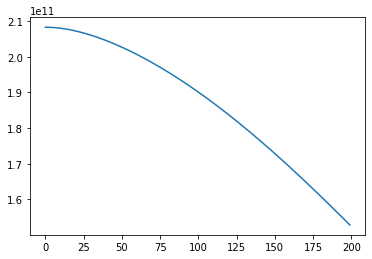

In [15]:
plt.plot(net.loss_curve_)

Looks like the error was clearly still going down but something in our model definition told it to stop at 200 epochs when there was clearly still room for improvement, hence the warning about not converging. Just for completeness' sake let's look at the mean absolute error for this under-trained under-optimized model

In [16]:
net_predictions = net.predict(X_test)
net_mae = mean_absolute_error(y_test, net_predictions)

print("Total error: $%.2f" %net_mae)

Total error: $467440.98


### Setting Neural Network Hyperparameters

It's time to start playing with some of the networks hyperparameters. There is no exact recipe for this and it is very problem dependant, so the key as always is to analyse and interpret the results and keep an iterative approach.

First let's start by taking a look at the available hyperparameters and examine the default values we used above. You can use `shift+tab` to see a list of parameters for the `MLPRegressor`. We will focus on 4 hyperparameters: 

* `max_iter` (number of epochs)
* `learning_rate_init` (value of learning rate)
* `hidden_layer_sizes` (the network architecture)
* `activation` (the activation function)

Try varying the values of these hyperparameters and examine the loss curve and the loss to make iterative adjustments!

We can start by increasing the number of epochs (or iterations) the network trains for. Let's double it:

Total error: $311233.02


/Users/tomas.rojo/opt/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


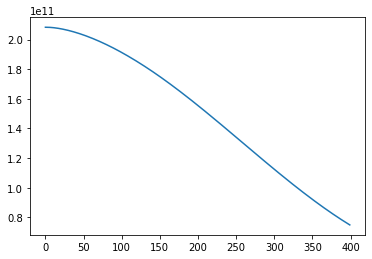

In [17]:
opt_net = MLPRegressor(max_iter=400)
opt_net.fit(X_train, y_train)

plt.plot(opt_net.loss_curve_)

opt_net_predictions = opt_net.predict(X_test)
opt_net_mae = mean_absolute_error(y_test, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

We can see some improvement but looks like there is still a lot of room to learn. We could keep increasing the number of epochs but we might end up having to wait for too long for it to train. Instead, let us try to increase the learning rate by a factor of 10 from the default value of 0.001:

Total error: $137884.98


/Users/tomas.rojo/opt/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


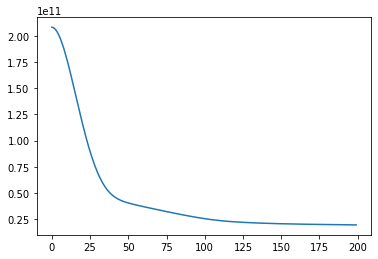

In [19]:
opt_net = MLPRegressor(max_iter=200, learning_rate_init=0.01)
opt_net.fit(X_train, y_train)

plt.plot(opt_net.loss_curve_)

opt_net_predictions = opt_net.predict(X_test)
opt_net_mae = mean_absolute_error(y_test, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

A lot better! But still some room for improvement, let's bring it up again, this time by a factor of 100:

Total error: $121720.56


/Users/tomas.rojo/opt/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


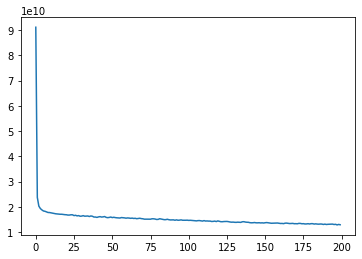

In [20]:
 opt_net = MLPRegressor(max_iter=200, learning_rate_init=1.0)
opt_net.fit(X_train, y_train)

plt.plot(opt_net.loss_curve_)

opt_net_predictions = opt_net.predict(X_test)
opt_net_mae = mean_absolute_error(y_test, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

The results are looking really good! We can even see that the network didn't even reach the 200 epochs that we set. That's because it noticed that the error was not decreasing after around the 110th epoch, and so it stops training to save us some time.

So far we have been using the default architecture with one hidden layer with 100 neurons each. Let's make the network a bit deeper by adding another hidden layer with 50 neurons in it. We will keep the learning rate from above:

Total error: $123833.97


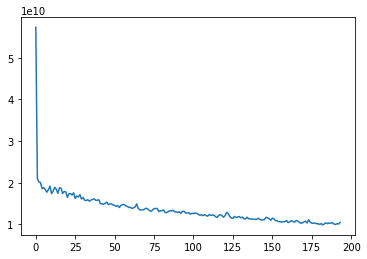

In [22]:
opt_net = MLPRegressor(
    max_iter=200,
    hidden_layer_sizes=(50, 25, 25, 25),
    activation='relu',
    learning_rate_init=0.1
)
opt_net.fit(X_train, y_train)

plt.plot(opt_net.loss_curve_)

opt_net_predictions = opt_net.predict(X_test)
opt_net_mae = mean_absolute_error(y_test, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

In [23]:
opt_net_predictions = opt_net.predict(X_train)
opt_net_mae = mean_absolute_error(y_train, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

Total error: $101982.36


Seems like with the recent change we have lost some of the previous improvements. This is natural as by adding the complexity of the model we are also vastly increasing the number of parameters that need to be learnt. This is important to keep in mind: **increasing the model complexity does not guarantee better results.**

One last thing we can try playing with is the activation function. By default, sklearn uses `ReLU` activation functions. In this last step let's try switching those to logistic (sigmoid). We will also revert back to the default architecture:

Total error: $141843.38


/Users/tomas.rojo/opt/miniconda3/envs/dev/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


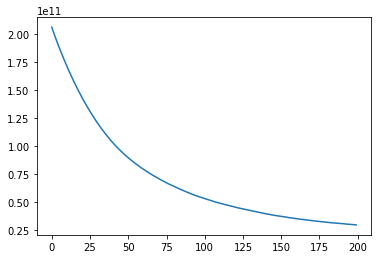

In [24]:
opt_net = MLPRegressor(max_iter=200, learning_rate_init=1.0, hidden_layer_sizes=(100,), activation='logistic')
opt_net.fit(X_train, y_train.ravel())

plt.plot(opt_net.loss_curve_)

opt_net_predictions = opt_net.predict(X_test)
opt_net_mae = mean_absolute_error(y_test, opt_net_predictions)

print("Total error: $%.2f" %opt_net_mae)

Looks like by changing our activation function we have made the model (with the current hyper-parameters) a little bit worse, but the good news is that it seems like there's still some room for more training. I encourage you to go back and re-visit some of of the hyperparameters to see if you can make this version of the network with logistic (sigmoid) units better than the one with ReLUs!

At this point it seems like our best model was the one with the default architecture, ReLU activations, and with a learning rate of 1.0. 